In [2]:
import pandas as pd

# Loading the dataset
file_path = "telecom_churn_data.csv"
df = pd.read_csv(file_path)

# Displaying basic info about the dataset
df_info = df.info()
df_head = df.head()

# Checking for missing values
missing_values = df.isnull().sum()

df_info, df_head, missing_values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


(None,
    mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
 0     7000842753        109             0.0             0.0             0.0   
 1     7001865778        109             0.0             0.0             0.0   
 2     7001625959        109             0.0             0.0             0.0   
 3     7001204172        109             0.0             0.0             0.0   
 4     7000142493        109             0.0             0.0             0.0   
 
   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
 0            6/30/2014            7/31/2014            8/31/2014   
 1            6/30/2014            7/31/2014            8/31/2014   
 2            6/30/2014            7/31/2014            8/31/2014   
 3            6/30/2014            7/31/2014            8/31/2014   
 4            6/30/2014            7/31/2014            8/31/2014   
 
   last_date_of_month_9   arpu_6  ...  sachet_3g_9  fb_user_6  fb_user_7  \
 0            9/30/

In [4]:
# Step 1: Converting date columns to datetime format
date_columns = ['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Step 2: Filtering High-Value Customers
# Calculating total recharge amount for first two months (good phase)
df['total_rech_amt_6'] = df[['total_rech_amt_6', 'total_rech_amt_7']].sum(axis=1) / 2
# 70th percentile of the average recharge amount
high_value_threshold = df['total_rech_amt_6'].quantile(0.70)
# Filtering high-value customers
high_value_customers = df[df['total_rech_amt_6'] >= high_value_threshold]

# Step 3: Handling Missing Values
# For simplicity, we'll fill missing values with 0 for now (can refine later)
high_value_customers.fillna(0, inplace=True)

# Step 4: Tagging Churners
# Churn condition: zero calls and zero internet usage in the last month
high_value_customers['churn'] = ((high_value_customers['total_ic_mou_9'] == 0) & 
                                 (high_value_customers['total_og_mou_9'] == 0) & 
                                 (high_value_customers['vol_2g_mb_9'] == 0) & 
                                 (high_value_customers['vol_3g_mb_9'] == 0)).astype(int)

# Step 5: Removing Attributes of the Churn Phase
churn_phase_columns = [col for col in high_value_customers.columns if '_9' in col]
high_value_customers.drop(columns=churn_phase_columns, inplace=True)

# Summary of steps
summary = {
    "Total Customers": len(df),
    "High-Value Customers": len(high_value_customers),
    "High-Value Threshold": high_value_threshold,
    "Churned Customers": high_value_customers['churn'].sum()
}

summary

C:\Users\rocky\AppData\Local\Temp\ipykernel_22208\1536095826.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  high_value_customers.fillna(0, inplace=True)
C:\Users\rocky\AppData\Local\Temp\ipykernel_22208\1536095826.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_value_customers.fillna(0, inplace=True)
C:\Users\rocky\AppData\Local\Temp\ipykernel_22208\1536095826.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

{'Total Customers': 99999,
 'High-Value Customers': 30011,
 'High-Value Threshold': 368.5,
 'Churned Customers': 2593}

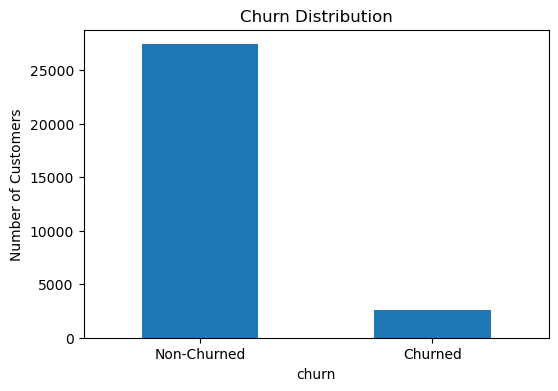

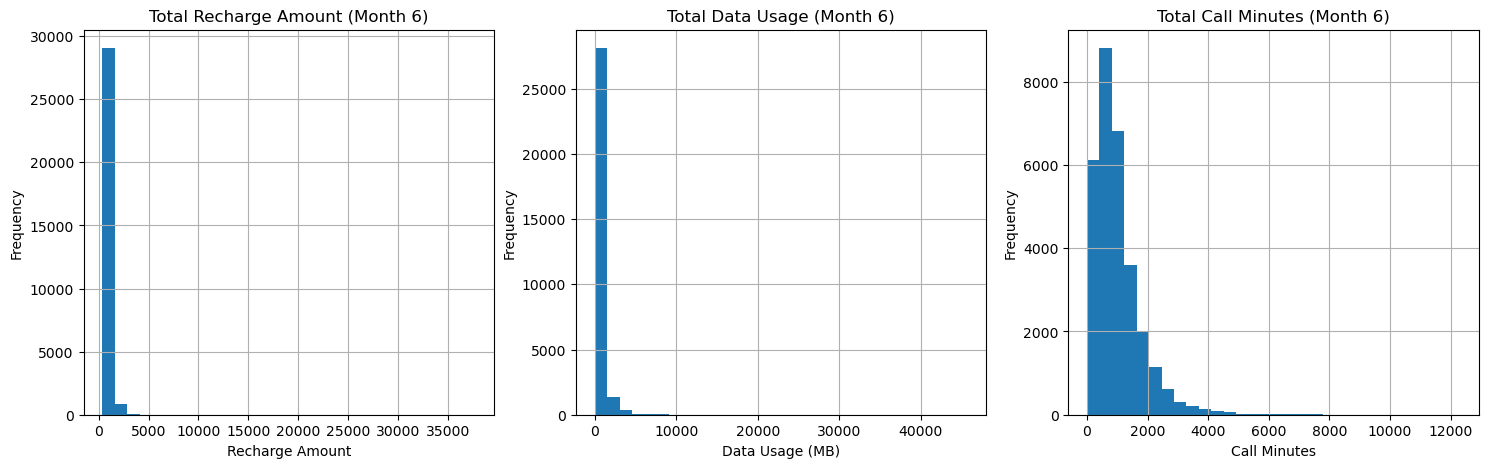

churn               1.000000
total_ic_mou_8      0.193407
loc_ic_mou_8        0.185884
arpu_8              0.182294
total_rech_amt_8    0.181299
total_og_mou_8      0.178737
loc_og_mou_8        0.175448
loc_og_t2m_mou_8    0.174892
loc_ic_t2m_mou_8    0.172744
fb_user_8           0.156720
total_rech_num_8    0.151955
Name: churn, dtype: float64


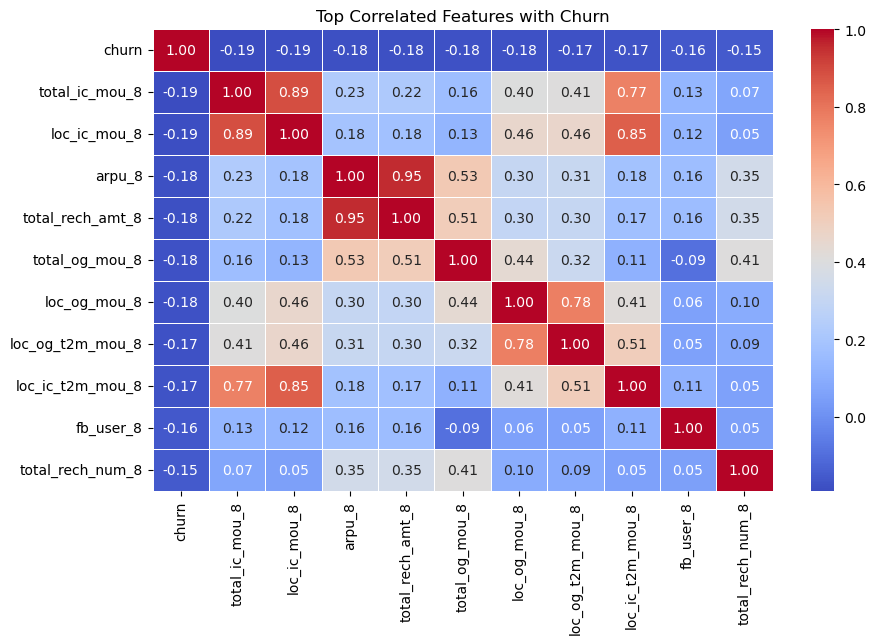

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Churn Distribution
plt.figure(figsize=(6, 4))
high_value_customers['churn'].value_counts().plot(kind='bar')
plt.xticks(ticks=[0, 1], labels=['Non-Churned', 'Churned'], rotation=0)
plt.ylabel("Number of Customers")
plt.title("Churn Distribution")
plt.show()

# Step 2: Key Feature Distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recharge Amount Distribution
high_value_customers['total_rech_amt_6'].hist(ax=axes[0], bins=30)
axes[0].set_title("Total Recharge Amount (Month 6)")
axes[0].set_xlabel("Recharge Amount")
axes[0].set_ylabel("Frequency")

# Data Usage Distribution (2G & 3G Combined)
high_value_customers[['vol_2g_mb_6', 'vol_3g_mb_6']].sum(axis=1).hist(ax=axes[1], bins=30)
axes[1].set_title("Total Data Usage (Month 6)")
axes[1].set_xlabel("Data Usage (MB)")
axes[1].set_ylabel("Frequency")

# Call Minutes Distribution (Incoming + Outgoing)
high_value_customers[['total_ic_mou_6', 'total_og_mou_6']].sum(axis=1).hist(ax=axes[2], bins=30)
axes[2].set_title("Total Call Minutes (Month 6)")
axes[2].set_xlabel("Call Minutes")
axes[2].set_ylabel("Frequency")

plt.show()

numeric_cols = high_value_customers.select_dtypes(include=['number'])
corr_matrix = numeric_cols.corr()
top_corr_features = corr_matrix['churn'].abs().sort_values(ascending=False).head(11)
print(top_corr_features)

# Selecting only numeric columns for correlation
numeric_cols = high_value_customers.select_dtypes(include=['number'])
corr_matrix = numeric_cols.corr()

# Getting top correlated features with churn
top_corr_features = corr_matrix['churn'].abs().sort_values(ascending=False).head(11).index
corr_subset = corr_matrix.loc[top_corr_features, top_corr_features]

# Plotting heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_subset, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Top Correlated Features with Churn")
plt.show()

In [ ]:
#Behavioral Trend Analysis

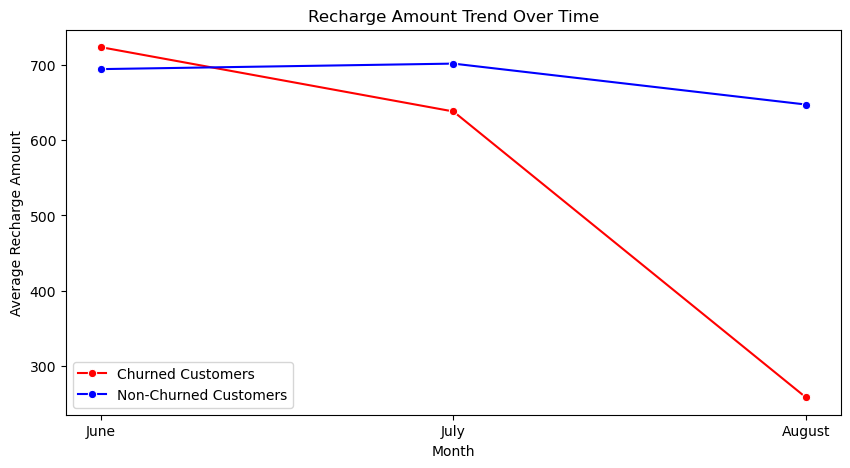

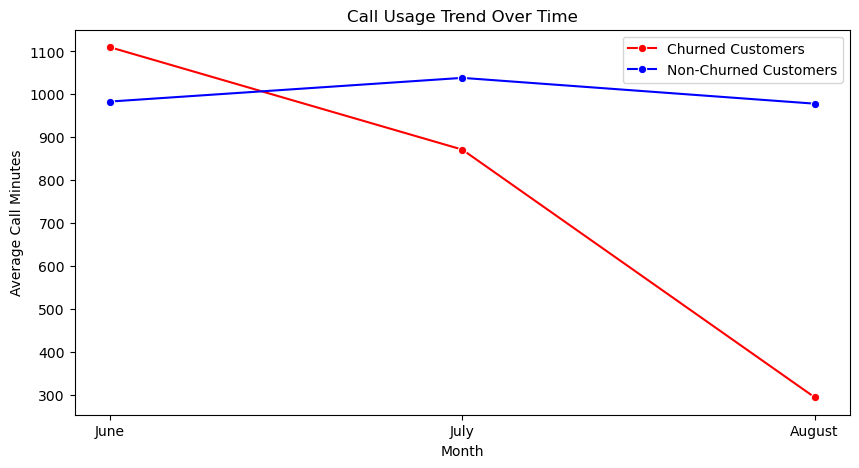

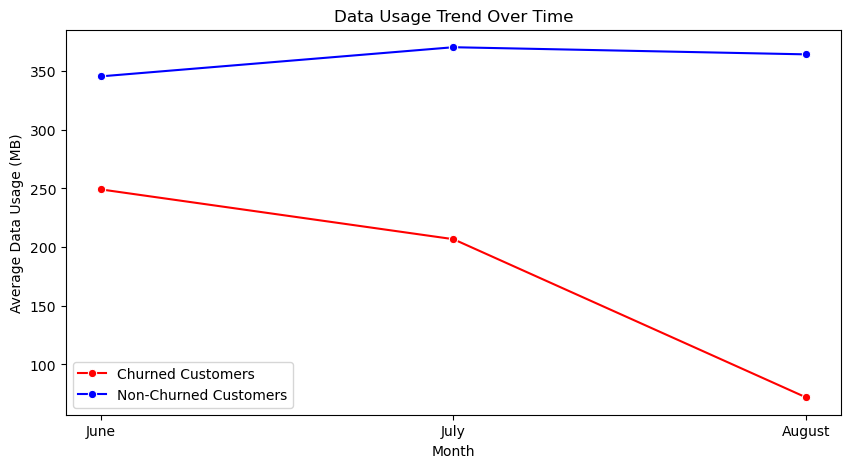

In [14]:
import seaborn as sns

# Step 1: Computing average values for churned vs. non-churned customers
churned = high_value_customers[high_value_customers['churn'] == 1]
non_churned = high_value_customers[high_value_customers['churn'] == 0]

# Step 2: Preparing data for visualization
trend_data = pd.DataFrame({
    'Month': ['June', 'July', 'August'],
    'Recharge (Churned)': [
        churned['total_rech_amt_6'].mean(), 
        churned['total_rech_amt_7'].mean(), 
        churned['total_rech_amt_8'].mean()
    ],
    'Recharge (Non-Churned)': [
        non_churned['total_rech_amt_6'].mean(), 
        non_churned['total_rech_amt_7'].mean(), 
        non_churned['total_rech_amt_8'].mean()
    ],
    'Calls (Churned)': [
        churned[['total_ic_mou_6', 'total_og_mou_6']].sum(axis=1).mean(), 
        churned[['total_ic_mou_7', 'total_og_mou_7']].sum(axis=1).mean(), 
        churned[['total_ic_mou_8', 'total_og_mou_8']].sum(axis=1).mean()
    ],
    'Calls (Non-Churned)': [
        non_churned[['total_ic_mou_6', 'total_og_mou_6']].sum(axis=1).mean(), 
        non_churned[['total_ic_mou_7', 'total_og_mou_7']].sum(axis=1).mean(), 
        non_churned[['total_ic_mou_8', 'total_og_mou_8']].sum(axis=1).mean()
    ],
    'Data (Churned)': [
        churned[['vol_2g_mb_6', 'vol_3g_mb_6']].sum(axis=1).mean(), 
        churned[['vol_2g_mb_7', 'vol_3g_mb_7']].sum(axis=1).mean(), 
        churned[['vol_2g_mb_8', 'vol_3g_mb_8']].sum(axis=1).mean()
    ],
    'Data (Non-Churned)': [
        non_churned[['vol_2g_mb_6', 'vol_3g_mb_6']].sum(axis=1).mean(), 
        non_churned[['vol_2g_mb_7', 'vol_3g_mb_7']].sum(axis=1).mean(), 
        non_churned[['vol_2g_mb_8', 'vol_3g_mb_8']].sum(axis=1).mean()
    ]
})

# Step 3: Plotting Recharge Amount Trends
plt.figure(figsize=(10, 5))
sns.lineplot(x='Month', y='Recharge (Churned)', data=trend_data, marker='o', label="Churned Customers", color='red')
sns.lineplot(x='Month', y='Recharge (Non-Churned)', data=trend_data, marker='o', label="Non-Churned Customers", color='blue')
plt.title("Recharge Amount Trend Over Time")
plt.ylabel("Average Recharge Amount")
plt.show()

# Step 4: Plotting Call Usage Trends
plt.figure(figsize=(10, 5))
sns.lineplot(x='Month', y='Calls (Churned)', data=trend_data, marker='o', label="Churned Customers", color='red')
sns.lineplot(x='Month', y='Calls (Non-Churned)', data=trend_data, marker='o', label="Non-Churned Customers", color='blue')
plt.title("Call Usage Trend Over Time")
plt.ylabel("Average Call Minutes")
plt.show()

# Step 5: Plotting Data Usage Trends
plt.figure(figsize=(10, 5))
sns.lineplot(x='Month', y='Data (Churned)', data=trend_data, marker='o', label="Churned Customers", color='red')
sns.lineplot(x='Month', y='Data (Non-Churned)', data=trend_data, marker='o', label="Non-Churned Customers", color='blue')
plt.title("Data Usage Trend Over Time")
plt.ylabel("Average Data Usage (MB)")
plt.show()


In [ ]:
#Feature Engineering

In [16]:
# Step 1: Creating Change Over Time (Delta) Features
high_value_customers['rech_amt_change_6_8'] = ((high_value_customers['total_rech_amt_8'] - 
                                                high_value_customers['total_rech_amt_6']) / 
                                                high_value_customers['total_rech_amt_6']) * 100

high_value_customers['call_usage_change_6_8'] = ((high_value_customers[['total_ic_mou_8', 'total_og_mou_8']].sum(axis=1) - 
                                                 high_value_customers[['total_ic_mou_6', 'total_og_mou_6']].sum(axis=1)) / 
                                                 high_value_customers[['total_ic_mou_6', 'total_og_mou_6']].sum(axis=1)) * 100

high_value_customers['data_usage_change_6_8'] = ((high_value_customers[['vol_2g_mb_8', 'vol_3g_mb_8']].sum(axis=1) - 
                                                  high_value_customers[['vol_2g_mb_6', 'vol_3g_mb_6']].sum(axis=1)) / 
                                                  high_value_customers[['vol_2g_mb_6', 'vol_3g_mb_6']].sum(axis=1)) * 100

# Step 2: Creating Aggregated Features
high_value_customers['total_calls_6'] = high_value_customers[['total_ic_mou_6', 'total_og_mou_6']].sum(axis=1)
high_value_customers['total_calls_7'] = high_value_customers[['total_ic_mou_7', 'total_og_mou_7']].sum(axis=1)
high_value_customers['total_calls_8'] = high_value_customers[['total_ic_mou_8', 'total_og_mou_8']].sum(axis=1)

high_value_customers['total_data_6'] = high_value_customers[['vol_2g_mb_6', 'vol_3g_mb_6']].sum(axis=1)
high_value_customers['total_data_7'] = high_value_customers[['vol_2g_mb_7', 'vol_3g_mb_7']].sum(axis=1)
high_value_customers['total_data_8'] = high_value_customers[['vol_2g_mb_8', 'vol_3g_mb_8']].sum(axis=1)

high_value_customers['total_rech_amt'] = high_value_customers[['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8']].sum(axis=1)

# Step 3: Creating Early Warning Indicator
high_value_customers['early_churn_risk'] = (high_value_customers['rech_amt_change_6_8'] < -30).astype(int)

# Step 4: Filling any remaining NaN values with 0 (to avoid calculation issues)
high_value_customers.fillna(0, inplace=True)

# Step 5: Displaying the newly created features
new_features = [
    'rech_amt_change_6_8', 'call_usage_change_6_8', 'data_usage_change_6_8',
    'total_calls_6', 'total_calls_7', 'total_calls_8',
    'total_data_6', 'total_data_7', 'total_data_8',
    'total_rech_amt', 'early_churn_risk'
]

# Show a sample of the new features
high_value_customers[new_features].head()

C:\Users\rocky\AppData\Local\Temp\ipykernel_22208\1235975411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_value_customers['rech_amt_change_6_8'] = ((high_value_customers['total_rech_amt_8'] -
C:\Users\rocky\AppData\Local\Temp\ipykernel_22208\1235975411.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_value_customers['call_usage_change_6_8'] = ((high_value_customers[['total_ic_mou_8', 'total_og_mou_8']].sum(axis=1) -
C:\Users\rocky\AppData\Local\Temp\ipykernel_22208\1235975411.py:10: Sett

,rech_amt_change_6_8,call_usage_change_6_8,data_usage_change_6_8,total_calls_6,total_calls_7,total_calls_8,total_data_6,total_data_7,total_data_8,total_rech_amt,early_churn_risk
7,207.004219,-30.080162,0.0,1113.99,1167.28,778.90,0.0,0.00,0.00,5613.0,0
8,-76.878613,-69.275751,inf,612.22,460.15,188.10,0.0,1106.95,11.97,1240.0,1
13,88.684211,15.145812,inf,1875.70,364.99,2159.79,0.0,0.00,0.02,1350.0,0
16,-65.141612,-25.830792,0.0,711.67,667.57,527.84,0.0,0.00,0.00,967.0,1
17,-92.647059,-100.000000,0.0,1341.41,3.12,0.00,0.0,0.00,0.00,438.0,1


In [28]:
import numpy as np

# Step 1: Identifying problematic columns
inf_columns = X.columns[np.isinf(X).any()].tolist()
print(f"Columns containing infinity values: {inf_columns}")

# Step 2: Replacing all infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 3: Filling NaN values with 0
X.fillna(0, inplace=True)

# Step 4: Clipping extreme values to a reasonable range (e.g., [-100, 100])
X = X.clip(lower=-100, upper=100)

# Step 5: Confirming there are no more problematic values
print("Any remaining inf values:", np.isinf(X).any().any())
print("Any remaining NaN values:", X.isna().sum().sum())

Columns containing infinity values: ['call_usage_change_6_8', 'data_usage_change_6_8']
Any remaining inf values: False
Any remaining NaN values: 0


C:\Users\rocky\AppData\Local\Temp\ipykernel_22208\2732635443.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\rocky\AppData\Local\Temp\ipykernel_22208\2732635443.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


In [ ]:
#Model Building - Handling Class Imbalance

In [34]:
# Checking the maximum and minimum values in the dataset
max_values = X.max()
min_values = X.min()

# Finding features with very large or very small values
large_values = max_values[max_values > 1e6]  # Any value greater than 1 million
small_values = min_values[min_values < -1e6]  # Any value less than -1 million

print("Columns with extremely large values:\n", large_values)
print("Columns with extremely small values:\n", small_values)


Columns with extremely large values:
 call_usage_change_6_8    inf
data_usage_change_6_8    inf
dtype: float64
Columns with extremely small values:
 Series([], dtype: float64)


In [36]:
# Clipping large values to a reasonable range
X = X.clip(lower=-1000, upper=1000)  # Adjust threshold as needed

# Verifying that all values are within a reasonable range
print("Max value in dataset after clipping:", X.max().max())
print("Min value in dataset after clipping:", X.min().min())

Max value in dataset after clipping: 1000.0
Min value in dataset after clipping: -100.0


In [38]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Step 1: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Applying SMOTE to Balance the Dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Step 3: Displaying New Class Distribution After SMOTE
print(y_train_smote.value_counts())

churn
0    21934
1    21934
Name: count, dtype: int64


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Step 1: Train Logistic Regression Model
log_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
log_model.fit(X_train_smote, y_train_smote)

# Step 2: Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_smote, y_train_smote)

# Step 3: Predictions on Test Set
y_pred_log = log_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Step 4: Model Evaluation
log_report = classification_report(y_test, y_pred_log, output_dict=True)
rf_report = classification_report(y_test, y_pred_rf, output_dict=True)

# Compute ROC-AUC Scores
log_auc = roc_auc_score(y_test, log_model.predict_proba(X_test)[:, 1])
rf_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

# Displaying results
model_performance = {
    "Model": ["Logistic Regression", "Random Forest"],
    "Precision": [log_report["1"]["precision"], rf_report["1"]["precision"]],
    "Recall": [log_report["1"]["recall"], rf_report["1"]["recall"]],
    "F1-score": [log_report["1"]["f1-score"], rf_report["1"]["f1-score"]],
    "ROC-AUC": [log_auc, rf_auc]
}

import pandas as pd
performance_df = pd.DataFrame(model_performance)

# Displaying results
print(performance_df)

                 Model  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression   0.296784  0.782274  0.430313  0.859743
1        Random Forest   0.405476  0.599229  0.483670  0.862308


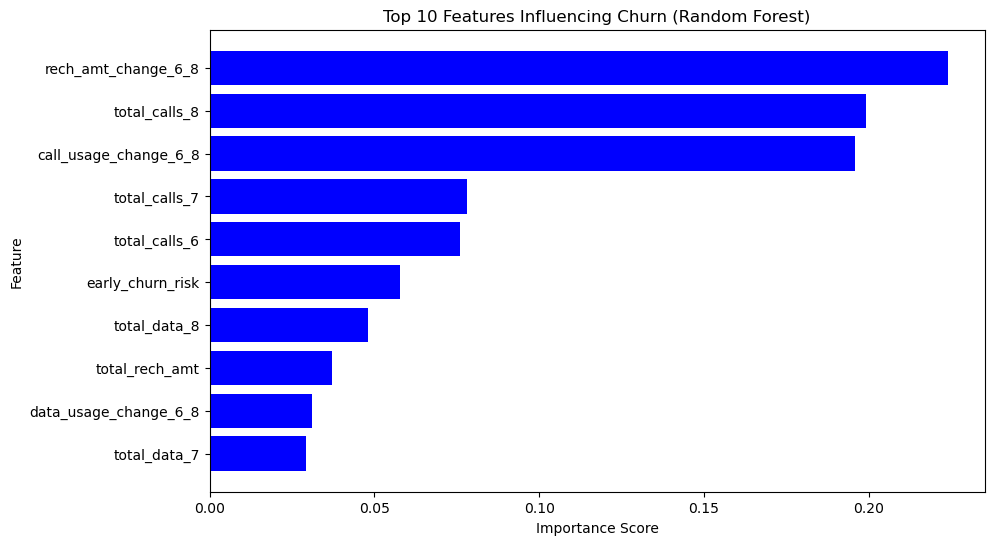

,Feature,Importance
0,rech_amt_change_6_8,0.223947
5,total_calls_8,0.199132
1,call_usage_change_6_8,0.195786
4,total_calls_7,0.078108
3,total_calls_6,0.076011
10,early_churn_risk,0.057690
8,total_data_8,0.048136
9,total_rech_amt,0.037012
2,data_usage_change_6_8,0.031070
7,total_data_7,0.029345


In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Extracting Feature Importance from Random Forest
feature_importance = rf_model.feature_importances_

# Step 2: Creating a DataFrame for Visualization
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)  # Top 10 features

# Step 3: Plotting Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Features Influencing Churn (Random Forest)")
plt.gca().invert_yaxis()  # Invert to show the highest importance at the top
plt.show()

# Displaying the feature importance values
importance_df

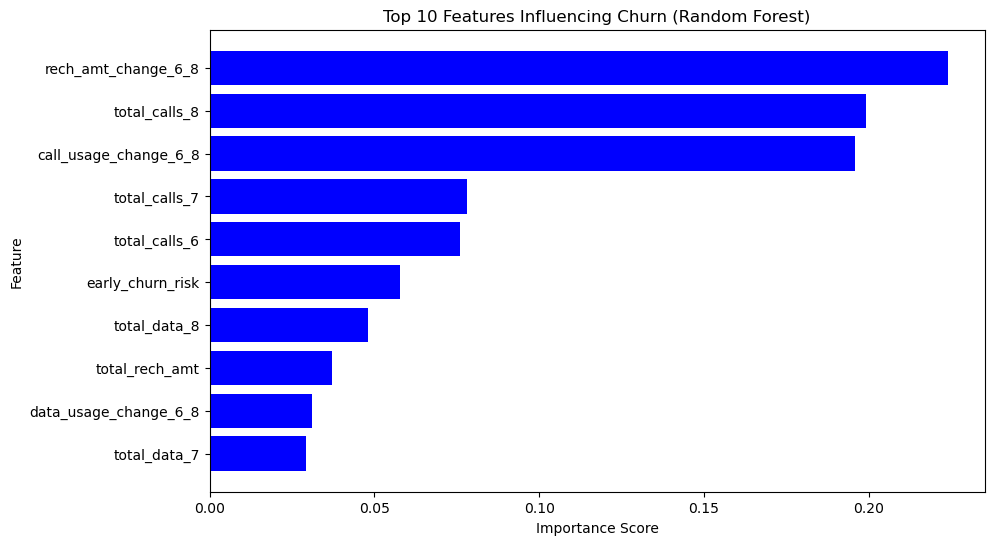

                  Feature  Importance
0     rech_amt_change_6_8    0.223947
5           total_calls_8    0.199132
1   call_usage_change_6_8    0.195786
4           total_calls_7    0.078108
3           total_calls_6    0.076011
10       early_churn_risk    0.057690
8            total_data_8    0.048136
9          total_rech_amt    0.037012
2   data_usage_change_6_8    0.031070
7            total_data_7    0.029345


In [46]:
from sklearn.ensemble import RandomForestClassifier

# Retraining Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_smote, y_train_smote)

# Proceeding with Feature Importance Analysis
feature_importance = rf_model.feature_importances_

# Creating a DataFrame for Visualization
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)  # Top 10 features

# Plotting Feature Importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Features Influencing Churn (Random Forest)")
plt.gca().invert_yaxis()  # Invert to show highest importance at the top
plt.show()

# Displaying feature importance values
print(importance_df)

In [56]:
from xgboost import XGBClassifier

# Step 1: Training XGBoost Model
xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_smote, y_train_smote)

# Step 2: Predictions on Test Set
y_pred_xgb = xgb_model.predict(X_test)

# Step 3: Model Evaluation
xgb_report = classification_report(y_test, y_pred_xgb, output_dict=True)
xgb_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

# Step 4: Updating Performance Comparison Table
model_performance["Model"].append("XGBoost")
model_performance["Precision"].append(xgb_report["1"]["precision"])
model_performance["Recall"].append(xgb_report["1"]["recall"])
model_performance["F1-score"].append(xgb_report["1"]["f1-score"])
model_performance["ROC-AUC"].append(xgb_auc)

# Converting to DataFrame
performance_df = pd.DataFrame(model_performance)

# Displaying updated model performance comparison
print(performance_df)

                 Model  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression   0.296784  0.782274  0.430313  0.859743
1        Random Forest   0.405476  0.599229  0.483670  0.862308
2              XGBoost   0.403244  0.670520  0.503618  0.856730


C:\Users\rocky\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [58]:
import joblib

# Saving the trained Random Forest model
joblib.dump(rf_model, "telecom_churn_model.pkl")

print("Model saved successfully!")

Model saved successfully!


In [60]:
# Loading the saved model
loaded_model = joblib.load("telecom_churn_model.pkl")

# Checking if the model loads correctly
print("Model loaded successfully!")

Model loaded successfully!


In [62]:
import pandas as pd

# Example: New customer data (ensure it has the same feature columns)
new_data = pd.DataFrame({
    'rech_amt_change_6_8': [-20],
    'call_usage_change_6_8': [-15],
    'data_usage_change_6_8': [-5],
    'total_calls_6': [800],
    'total_calls_7': [750],
    'total_calls_8': [600],
    'total_data_6': [500],
    'total_data_7': [450],
    'total_data_8': [300],
    'total_rech_amt': [1500],
    'early_churn_risk': [1]
})

# Using the loaded model to predict churn
prediction = loaded_model.predict(new_data)

# Output the prediction (1 = Churn, 0 = No Churn)
print("Churn Prediction:", prediction[0])

Churn Prediction: 0
